In [6]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, RegressorMixin
from typing import Dict


class LRBoostRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, primary_model=None, secondary_model=None):
        if primary_model is None:
            primary_model = RidgeCV()

        if secondary_model is None:
            secondary_model = HistGradientBoostingRegressor()

        self.primary_model = primary_model
        self.secondary_model = secondary_model
        self.secondary_type = type(self.secondary_model).__name__

    def __sklearn_is_fitted__(self):
        """Internal sklearn helper that indicates the object has been fitted

        Returns:
            bool: True
        """
        return True

    def fit(self, X, y, sample_weight=None):
        """Fits both the primary and secondary estimator and returns fitted LRBoostRegressor

        Args:
            X (array-like): Input features
            y (array-like): Raw target
            sample_weight (array-like, optional): Sample weights for estimators.
                Only accepts one weight for both. Defaults to None.

        Returns:
            self: Fitted LRBoostRegressor
        """
        self._fit_primary_model(X, y, sample_weight=sample_weight)
        self.primary_residual = np.subtract(self.primary_prediction, y)
        self._fit_secondary_model(X, self.primary_residual, sample_weight=sample_weight)

        return self

    def _fit_primary_model(self, X, y, sample_weight=None):
        self.primary_model.fit(X, y, sample_weight=sample_weight)
        self.primary_prediction = self.primary_model.predict(X)

    def _fit_secondary_model(self, X, y, sample_weight=None):
        self.secondary_model.fit(X, y, sample_weight=sample_weight)

    def predict(self, X, detail=False):
        """[summary]

        Args:
            X (array-type): Input features
            detail (bool, optional):  Flag to include primary and secondary predictions.
                Defaults to False.

        Returns:
            Dict: If detail=True with primary, secondary, and final predictions.
            np.array: If detail=False just final predictions.
        """
        check_is_fitted(self)
        primary_prediction = self.primary_model.predict(X)

        if self.secondary_type == "NGBRegressor":
            secondary_prediction = self.secondary_model.pred_dist(X).loc
        elif self.secondary_type == "XGBDistribution":
            secondary_prediction = self.secondary_model.predict(X).loc
        else:
            secondary_prediction = self.secondary_model.predict(X)

        if detail:

            preds = {
                "primary_prediction": primary_prediction,
                "secondary_prediction": secondary_prediction,
                "final_prediction": np.subtract(
                    primary_prediction, secondary_prediction
                ),
            }

        else:
            preds = np.subtract(primary_prediction, secondary_prediction)

        return preds

    def predict_dist(self, X) -> tuple:
        """[summary]

        Args:
            X (array-like): Input features

        Raises:
            Exception: Throws error if non probabilistic model used.

        Returns:
            tuple: final prediction, sd of secondary prediction
        """
        check_is_fitted(self)

        if not self.secondary_type in ["NGBRegressor", "XGBDistribution"]:
            raise Exception(
                "predict_dist() method requires an NGboostRegressor or XGBDistribution object"
            )

        if self.secondary_type == "NGBRegressor":
            preds = self.secondary_model.pred_dist(X)
            final_prediction = np.add(preds.loc, self.primary_model.predict(X))
            return final_prediction, preds.scale

        if self.secondary_type == "XGBDistribution":
            preds = self.secondary_model.predict(X)
            final_prediction = np.add(preds.loc, self.primary_model.predict(X))
            return final_prediction, preds.scale

    def fit_and_tune(
        self,
        X,
        y,
        tuner,
        param_distributions,
        sample_weight=None,
        primary_fit_params=None,
        secondary_fit_params=None,
        *tuner_args,
        **tuner_kwargs
    ):
        """[summary]

        Args:
            X ([type]): [description]
            y ([type]): [description]
            tuner ([type]): [description]
            param_distributions ([type]): [description]
            sample_weight ([type], optional): [description]. Defaults to None.
            primary_fit_params ([type], optional): [description]. Defaults to None.
            secondary_fit_params ([type], optional): [description]. Defaults to None.

        Raises:
            Exception: [description]

        Returns:
            [type]: [description]
        """
        if primary_fit_params is None:
            primary_fit_params = {}

        if (
            "sample_weight" in primary_fit_params
            or "sample_weight" in secondary_fit_params
        ) and sample_weight is not None:
            raise Exception("Conflicting sample weights.")

        self._fit_primary_model(X, y, sample_weight=sample_weight, **primary_fit_params)
        self._tune_secondary_model(
            tuner,
            param_distributions,
            X,
            y,
            *tuner_args,
            sample_weight=sample_weight,
            fit_params=secondary_fit_params,
            **tuner_kwargs
        )
        return self

    def _tune_secondary_model(
        self,
        tuner,
        param_distributions,
        X,
        y,
        *tuner_args,
        sample_weight=None,
        secondary_fit_params=None,
        **tuner_kwargs
    ):
        """[summary]

        Args:
            tuner ([type]): [description]
            param_distributions ([type]): [description]
            X ([type]): [description]
            y ([type]): [description]
            sample_weight ([type], optional): [description]. Defaults to None.
            secondary_fit_params ([type], optional): [description]. Defaults to None.
        """
        check_is_fitted(self.primary_model)
        if secondary_fit_params is None:
            secondary_fit_params = {}

        self.secondary_model = (
            tuner(
                self.secondary_model, param_distributions, *tuner_args, **tuner_kwargs
            )
            .fit(X, y, sample_weight=sample_weight, **secondary_fit_params)
            .best_estimator_
        )

            

In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

clutch = pd.read_csv("../examples/clutch_vs_nonclutch_minutes.csv")

high_min_players = clutch.loc[clutch.loc['clutch']]



In [26]:
lrb = LRBoostRegressor()
lrb.fit(X_train, y_train.ravel())
detailed_predictions = lrb.predict(X_test, detail=True)
primary_predictions = detailed_predictions['primary_prediction']
lrb_predictions = detailed_predictions['final_prediction']


In [27]:
hgb = HistGradientBoostingRegressor()
hgb.fit(X_train, y_train.ravel())
hgb_predictions = hgb.predict(X_test)

In [30]:
print(f"Primary RMSE: {round(mean_squared_error(primary_predictions, y_test.ravel()), 2)}")
print(f"LRBoost RMSE: {round(mean_squared_error(lrb_predictions, y_test.ravel()), 2)}")
print(f"HistGradientBoostingRegressor RMSE: {round(mean_squared_error(hgb_predictions, y_test.ravel()), 2)}")

Primary RMSE: 11.73
LRBoost RMSE: 13.28
HistGradientBoostingRegressor RMSE: 11.47


In [73]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import LassoCV

concrete = pd.read_csv("../examples/concrete_data.csv")
features = ['cement', 'slag', 'fly_ash', 'water', 'superplastic', 'coarse_agg', 'fine_agg', 'age', 'cw_ratio']
target = 'ccs'

def evaluate_models(X_train, X_test, y_train, y_test):
    lrb = LRBoostRegressor(primary_model=RidgeCV(alphas=np.logspace(-4, 3, 10, endpoint=True)))
    lrb.fit(X_train, y_train.ravel())
    detailed_predictions = lrb.predict(X_test, detail=True)
    primary_predictions = detailed_predictions['primary_prediction']
    lrb_predictions = detailed_predictions['final_prediction']
    hgb = HistGradientBoostingRegressor()
    hgb.fit(X_train, y_train.ravel())
    hgb_predictions = hgb.predict(X_test)
    print(f"Ridge RMSE: {round(mean_squared_error(primary_predictions, y_test.ravel()), 2)}")
    print(f"HistGradientBoostingRegressor RMSE: {round(mean_squared_error(hgb_predictions, y_test.ravel()), 2)}")
    print(f"LRBoost RMSE: {round(mean_squared_error(lrb_predictions, y_test.ravel()), 2)}")


In [74]:
## Scenario 1: 75/25 train/test
X_train, X_test, y_train, y_test = train_test_split(concrete[features], concrete[target], train_size=0.75, random_state=100)
evaluate_models(X_train, X_test, y_train, y_test)

Ridge RMSE: 112.4
HistGradientBoostingRegressor RMSE: 26.33
LRBoost RMSE: 25.06


In [75]:
## Scenario 1: 50/50 train/test
X_train, X_test, y_train, y_test = train_test_split(concrete[features], concrete[target], train_size=0.50, random_state=100)
evaluate_models(X_train, X_test, y_train, y_test)

Ridge RMSE: 107.6
HistGradientBoostingRegressor RMSE: 26.6
LRBoost RMSE: 23.55


In [78]:
## Scenario 3: Training: CCS > 25, Testing: CCS <= 25
train = concrete.loc[concrete['ccs'] > 25]
test = concrete.loc[concrete['ccs'] <= 25]
X_train = train[features]
y_train = train[target]
X_test = train[features]
y_test = train[target]
evaluate_models(X_train, X_test, y_train, y_test)

Ridge RMSE: 89.26
HistGradientBoostingRegressor RMSE: 4.21
LRBoost RMSE: 3.7


In [3]:
from sklearn.datasets import load_diabetes
from lrboost import LRBoostRegressor
X, y = load_diabetes(return_X_y=True)
lrb = LRBoostRegressor().fit(X, y)
predictions = lrb.predict(X)
detailed_predictions = lrb.predict(X, detail=True)
print(lrb.primary_model.score(X, y))
print(lrb.score(X, y))

0.5125629767961006
0.9332998430230678


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

clutch = pd.read_csv('../examples/clutch.csv')

#train_mask = (clutch['nonclutch_min'] <= 4000) & (clutch['nonclutch_min'] >= 750)
#train = clutch[train_mask]
#test = clutch[~train_mask]

train, test = train_test_split(clutch)

X_train = train[['nonclutch_min']]
y_train = train['clutch_min']

X_test = test[['nonclutch_min']]
y_test = test['clutch_min']

gbm = HistGradientBoostingRegressor(max_iter=500, random_state=42).fit(X_train, y_train)
lrb = LRBoostRegressor(secondary_model=HistGradientBoostingRegressor(max_iter=500, random_state=42)).fit(X_train, y_train)

print(f"Ridge RMSE: {round(mean_squared_error(lrb.primary_model.predict(X_test), y_test), 2)}")
print(f"HistGradientBoostingRegressor RMSE: {round(mean_squared_error(gbm.predict(X_test), y_test), 2)}")
print(f"LRBoost RMSE: {round(mean_squared_error(lrb.predict(X_test), y_test), 2)}")

Ridge RMSE: 570.01
HistGradientBoostingRegressor RMSE: 743.66
LRBoost RMSE: 733.4


In [11]:
clutch = pd.read_csv('../examples/clutch.csv')
train_mask = (clutch['nonclutch_min'] <= 4000) & (clutch['nonclutch_min'] >= 750)
clutch['Set'] = ["Train" if (x <= 4000) & (x >= 750) else "Test" for x in clutch['nonclutch_min']]


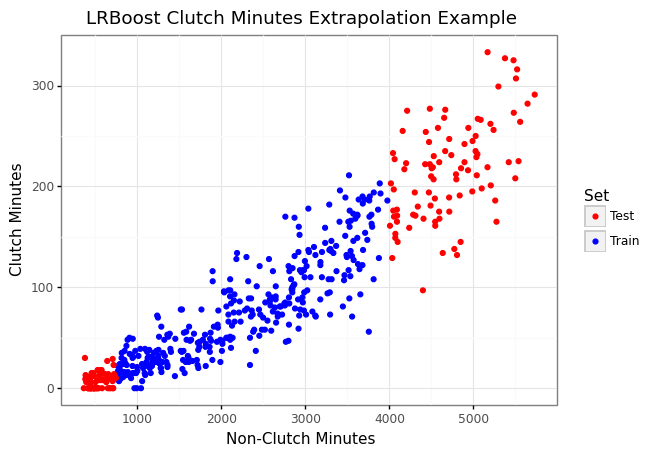

<ggplot: (353340874)>

In [13]:
from plotnine import *

(

    ggplot(clutch) +
        geom_point(aes(x = "nonclutch_min", y = "clutch_min", color = "Set")) +
        scale_color_manual(values = ["red", "blue"]) +
        labs(x = "Non-Clutch Minutes",
            y = "Clutch Minutes",
            title = "LRBoost Clutch Minutes Extrapolation Example") +
        theme_bw()

)